In [1]:
from googleads import adwords
import pandas as pd
import numpy as np
import datetime
import math
import gdn_datacollector as datacollector
import gdn_db

In [2]:
CREDIBLE_INTERVAL = 0.95

In [7]:
adwords_client = adwords.AdWordsClient.LoadFromStorage(datacollector.AUTH_FILE_PATH)

In [4]:
def get_performance_insights( customer_id=None, date_preset=None, performance_type='PLACEMENT'):
    report_downloader = adwords_client.GetReportDownloader(version='v201809')
    operand = [
        {
            'field': 'ExternalCustomerId',
            'operator': 'EQUALS',
            'values': None
        },
    ]
    report = {
        'downloadFormat': 'CSV',
        'reportName': None,
        'reportType': None,
        'dateRangeType': date_preset,
        'selector': {
            'fields': None,
            'predicates': operand
        }
    }
    operand[0]['values']=[customer_id]
    if performance_type == 'PLACEMENT':
        report['reportName']='PLACEMENT_PERFORMANCE_REPORT'
        report['reportType']='PLACEMENT_PERFORMANCE_REPORT'

        _LIST = [
        'ExternalCustomerId', 'Id', 'Cost', 'Ctr', 'Clicks', 'Impressions', 'AllConversions', 'Conversions', 'Criteria', 'DisplayName']
    elif performance_type == 'URL':
        report['reportName']='URL_PERFORMANCE_REPORT'
        report['reportType']='URL_PERFORMANCE_REPORT'

        _LIST = [
        'ExternalCustomerId', 'Cost', 'Ctr', 'CriteriaParameters', 'DisplayName', 'Domain']

    report['selector']['fields'] = _LIST

    if date_preset is None:
        date_preset=datacollector.DatePreset.lifetime
    with open(performance_type+'.csv', 'wb') as output_file:
        report_downloader.DownloadReport(
            report, output=output_file, skip_report_header=True, skip_column_header=False,
            skip_report_summary=True, include_zero_impressions=False)
    with open(performance_type+'.csv')as csv_file:
        df = pd.read_csv(csv_file, sep=",", quotechar='"')
        try:
            df['CTR'] = df.CTR.str.split('%', expand = True)[0]
        except KeyError as e:
            print('[gsn_datacollector.Campaign.get_performance_insights]: ', performance_type, e)
            pass
        df = df.sort_values(by=['Cost'], ascending=False).reset_index(drop=True)
        return df

In [5]:
def select_abnormal_insights(customer_id):
    adwords_client.SetClientCustomerId(customer_id)
    df = get_performance_insights(customer_id=customer_id, date_preset=datacollector.DatePreset.lifetime, performance_type='PLACEMENT')
    df = df.apply(pd.to_numeric, errors='ignore')
    df_temp = df[(df.Cost!=0)]
    df_temp = df_temp[(df_temp.Clicks>10)]
    df_temp = df_temp[(df_temp['All conv.']==0)]
    df_temp = df_temp[(df_temp.Impressions>df_temp.Clicks)].sort_values(by=['CTR'], ascending=False).reset_index(drop=True)
    df_temp[['Cost']] = df_temp['Cost'].div(1000000)
    df_abnormal = df_temp.sort_values(by=['CTR'], ascending=False)[df_temp.CTR>df_temp.CTR.quantile(CREDIBLE_INTERVAL)].reset_index(drop=True)
    return df_abnormal

In [6]:
def main():
    df_performance_campaign = gdn_db.get_performance_campaign_is_running()
    campaign_id_list = df_performance_campaign['campaign_id'].tolist()
    print('[optimize_performance_campaign]: campaign_id_list', campaign_id_list)
    for campaign_id in campaign_id_list:
        customer_id = df_performance_campaign['customer_id'][df_performance_campaign.campaign_id==campaign_id].iloc[0]
        df_abnormal = select_abnormal_insights(customer_id)
        df_mobile = df_abnormal[df_abnormal.Placement.str.contains("mobileapp")].reset_index(drop=True)
        df_placement = df_abnormal[~df_abnormal.Placement.str.contains("mobileapp")].reset_index(drop=True)
        # Make criterions
        criterions = []
        for idx, row in df_mobile.iterrows():
            criterion = {}
            criterion['xsi_type'] = 'MobileApplication'
            criterion['appId'] = row.Placement.split("::")[1]
            criterions.append(criterion)

        for idx, row in df_placement.iterrows():
            criterion = {}
            criterion['xsi_type'] = 'Placement'
            criterion['url'] = row.Placement
            criterions.append(criterion)
            
        for criterion in criterions:
            resp = update_placement_status(client=adwords_client, campaign_id=campaign_id, criterion=criterion)
            print(resp)

In [7]:
def retrieve_placement_params(client, campaign_id):
    _FIELDS = ['CampaignId', 'ChannelName', 'CriteriaType', 'Id', 'PlacementUrl']
    selector = [ {
        'fields': _FIELDS,
        'predicates': [ {
            'field': 'CampaignId',
            'operator': 'EQUALS',
            'values': [campaign_id]
        } ]
    } ]
    ad_group_criteron_service = adwords_client.GetService('AdGroupCriterionService', version='v201809')
    ad_group_criteron_params = ad_group_criteron_service.get(selector)
    return ad_group_criteron_params

In [8]:
def update_placement_status(client, campaign_id, criterion):
    customer_negative_criterion_service = adwords_client.GetService('CampaignCriterionService', version='v201809')
    negative_campaign_criterion_operand = {
        'xsi_type': 'NegativeCampaignCriterion',
        'campaignId': campaign_id,
        'criterion': criterion
    }
    if 'id' in criterion:
        operator = 'REMOVE'
    elif 'appId' in criterion and criterion['xsi_type']=='MobileApplication':
        operator = 'ADD'
    elif 'url' in criterion and criterion['xsi_type']=='Placement':
        operator = 'ADD'

    operations = []
    operations.append({
      'operator': operator,
      'operand': negative_campaign_criterion_operand
    })
    result = customer_negative_criterion_service.mutate(operations)
    return result

In [9]:
if __name__=='__main__':
    main()

[optimize_performance_campaign]: campaign_id_list [2025332309]


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


{
    'ListReturnValue.Type': 'CampaignCriterionReturnValue',
    'value': [
        {
            'campaignId': 2025332309,
            'isNegative': True,
            'criterion': {
                'id': 445816118307,
                'type': 'MOBILE_APPLICATION',
                'Criterion.Type': 'MobileApplication',
                'appId': '2-com.nuotec.fastcharger',
                'displayName': None
            },
            'bidModifier': None,
            'campaignCriterionStatus': None,
            'baseCampaignId': None,
            'forwardCompatibilityMap': [],
            'CampaignCriterion.Type': 'NegativeCampaignCriterion'
        }
    ],
    'partialFailureErrors': []
}
{
    'ListReturnValue.Type': 'CampaignCriterionReturnValue',
    'value': [
        {
            'campaignId': 2025332309,
            'isNegative': True,
            'criterion': {
                'id': 543296770451,
                'type': 'MOBILE_APPLICATION',
                'Criterion.Type': 'M

In [12]:
#!jupyter nbconvert --to script gdn_abnormal_placement_detection.ipynb

[NbConvertApp] Converting notebook gdn_abnormal_placement_detection.ipynb to script
[NbConvertApp] Writing 5995 bytes to gdn_abnormal_placement_detection.py


In [8]:
adwords_client.SetClientCustomerId(3207327801)

In [9]:
# df = select_abnormal_insights(customer_id=3207327801)
df = get_performance_insights(customer_id=3207327801, date_preset=datacollector.DatePreset.lifetime, performance_type='PLACEMENT')
df = df.apply(pd.to_numeric, errors='ignore')
df = df[df.Cost>0]

In [10]:
df

,Customer ID,Criterion ID,Cost,CTR,Clicks,Impressions,All conv.,Conversions,Placement,Criteria Display Name
0,3207327801,--,8784935596,0.25,2160,852143,39.0,3.0,youtube.com,youtube.com
1,3207327801,--,3589733362,0.18,457,258572,68.0,3.0,pixnet.net,pixnet.net
2,3207327801,--,3444617611,0.17,780,458425,14.0,3.0,youtube.com,youtube.com
3,3207327801,--,3028506561,0.07,464,675844,89.0,10.0,anonymous.google,anonymous.google
4,3207327801,--,2521369616,0.20,693,341374,18.0,2.0,youtube.com,youtube.com
5,3207327801,--,2472791454,0.16,422,270831,65.0,10.0,yahoo.com,yahoo.com
6,3207327801,--,2412450000,0.12,455,384435,0.0,0.0,i-gamer.net,i-gamer.net
7,3207327801,--,2341290000,0.06,416,651334,5.0,2.0,anonymous.google,anonymous.google
8,3207327801,--,2227507625,0.43,640,149977,16.0,2.0,youtube.com,youtube.com
9,3207327801,--,2212520000,0.21,264,124187,10.0,5.0,pixnet.net,pixnet.net


In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


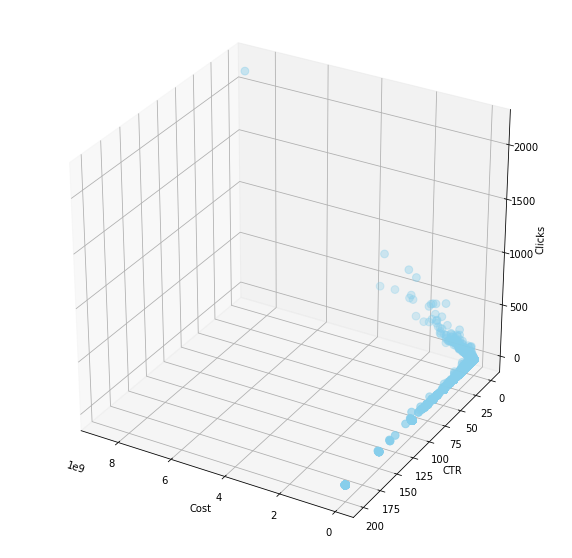

In [23]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Cost'], df['CTR'], df['Clicks'], c='skyblue', s=60)
# for i in range(len(df)): #plot each point + it's index as text above
#     ax.scatter(df['Cost'].iloc[i],df['CTR'].iloc[i],df['Clicks'].iloc[i],color='b') 
#     ax.text(df['Cost'].iloc[i],df['CTR'].iloc[i],df['Clicks'].iloc[i], '%s' % (df['Criteria Display Name'].iloc[i]), size=20, zorder=1, color='k')
ax.set_xlabel('Cost')
ax.set_ylabel('CTR')
ax.set_zlabel('Clicks')
ax.view_init(30, 120)